# Markov Chain Monte-Carlo (MCMC) #
Author: Harold Soh
Date: 17 March 2020

Code to accompany Lecture 9 on sampling and MCMC.

A large part of this tutorial will be on estimating integrals which are **intractable** and/or have no closed form solution. In particular, we are often interested in estimating **expectations** $$\mathbb{E}_{x\sim p(x)}[f(x)]$$ but where $p(x)$ is difficult to sample from. In general, we will assume that $p(z)$ is known up to the normalization constant:
$$p(x) = \frac{1}{C}\widehat{p}(x)$$
In other words, we know $\widehat{p}$ but not $C$ ($C$ is usually a difficult integral)

*Note:* Code written to emphasize readability, not efficiency. 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import numpy.random as random
from numpy import log, exp
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy as sp

import pandas as pd
from pandas.tools.plotting import autocorrelation_plot


ModuleNotFoundError: No module named 'pandas.tools'

In [ ]:
#filter warnings
import warnings
warnings.filterwarnings('ignore')

## Estimating $\mathbb{E}_{x}[f(x)]$ via Monte-Carlo##

Given $f(x)$ that can be very complex, we want to compute $\mathbb{E}_{x\sim\mathcal{N}}[f(x)]$

In [ ]:
def f(x):
    return np.cos(x)*(x**(3/3))

xs = np.arange(-10,10,0.01)
plt.plot(xs, f(xs), label='$f(x)$')
_ = plt.legend()


In [ ]:
normpdf = stats.norm(3, 1)

In [ ]:
N = 100000
x = normpdf.rvs(N)

estimate = np.mean(f(x))
print("Estimated expectation: ", estimate)

But is this a good estimate? 

Also, what if I can't sample from $p(x)$ ? What if $p(x)$ didn't have a nice closed form expression like the normal distribution?


## Estimating $\pi$ : Monte-Carlo style##

In [3]:
def plotCircle(n=200):
    d = 2*np.pi/n
    x = np.cos(np.arange(0,np.pi/2 + 0.01,d))
    y = np.sin(np.arange(0,np.pi/2 + 0.01,d))   
    plt.plot(x,y)
    plt.ylim(0,1)
    plt.xlim(0,1)

def estimatePi(N=1000, boxsize=1.0, doplot=True):
    
    # randomly sample N points in the box
    x = random.uniform(0, boxsize, N)
    y = random.uniform(0, boxsize, N)

    # check if the points are in the circle
    t = x**2 + y**2 <= 1

    ic = np.where(t == True)[0] #inside indices
    oc = np.where(t == False)[0] #outside indices
    
    # compute the area, 
    # for r = 1, this is also our estimate for pi 
    # since pi*r^2 = pi when r = 1
    Nin = ic.shape[0]
    pi_est = 4*(Nin/N)*((boxsize)**2)
    
    if doplot:
        plt.scatter(x[ic],y[ic], c='green')
        plt.scatter(x[oc],y[oc], c='red', marker='.')
    
    return pi_est

Estimate for pi: 3.124


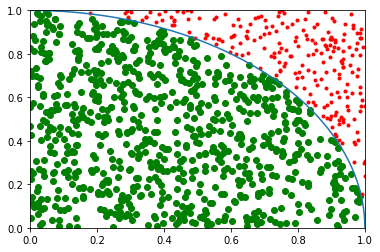

In [4]:
plotCircle()
pi_est = estimatePi(N=1000, boxsize=1.0)
print("Estimate for pi:", pi_est)

Text(0, 0.5, 'Absolute Error')

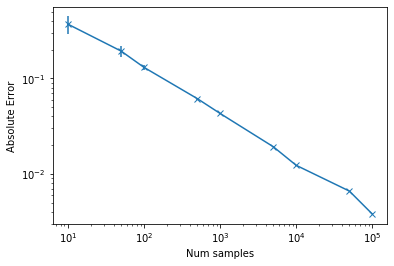

In [5]:
# let's plot how the  error from the  true pi 
# changes as we increase the number of samples
ns = [10,50, 100, 500, 1000, 5000, 10000, 50000, 100000]
err = np.zeros(len(ns))
errvar = np.zeros(len(ns))
for i in range(len(ns)):
    n = ns[i]
    pij = np.zeros(100)
    for j in range(100):
        pij[j] = estimatePi(N=n, boxsize=1.0,doplot=False)
    err[i] = np.mean(np.abs(pij - np.pi))
    errvar[i] = np.var(np.abs(pij - np.pi))

plt.errorbar(ns, err, yerr=errvar, marker='x')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Num samples")
plt.ylabel("Absolute Error")

In [6]:
# distribution of estimates
M = 10000
pis = [estimatePi(N=10000, boxsize=1.0, doplot=False) for i in range(M)]

mean: 3.141585, variance: 0.000262


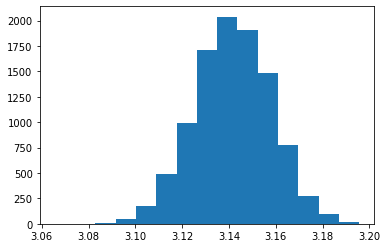

In [7]:
freqs = plt.hist(pis, bins=15)
print("mean: %f, variance: %f"%(np.mean(pis), np.var(pis)))

## Rejection Sampling  ##

Estimating the Expectation of a Gamma Distribution

$$p(x | a,b) = \mathrm{Gamma}(x|a,b) = \frac{1}{\Gamma(a)}b^a x^{a-1} \exp(-bx)$$

In [8]:

import numpy as np
import scipy as sp

def GammaUnnorm(x, a=1.99, b=1):
    return np.nan_to_num((b**a) * (x**(a-1)) * np.exp(-b*x))

def Gamma(x, a=1.99, b=1):
    return GammaUnnorm(x, a=a, b=b)/sp.special.gamma(a)


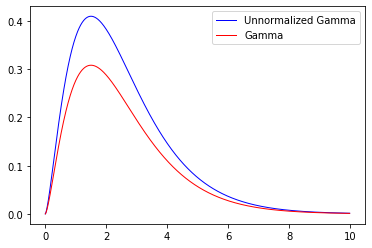

In [9]:
# plot the unnormalized gamma distribution
a = 2.5
b = 1
x  = np.arange(0,10, 0.01)
phat = GammaUnnorm(x, a=a, b=b)
plt.plot(x, phat , 'b-', lw=1, label='Unnormalized Gamma')

phat = Gamma(x, a=a, b=b)
plt.plot(x, phat , 'r-', lw=1, label='Gamma')

plt.legend()

##  Estimation with a Normal proposal##

In [10]:

def rejSamplingDemo(a,b, qpdf, k, N=10000):
    
    x = qpdf.rvs(size=N)
    u = random.uniform(0,1,N)

    t = u < GammaUnnorm(x, a=a, b=b)/(k*qpdf.pdf(x)) 

    ic = np.where(t == True)[0] #inside indices

    # compute Expectation
    estmean = np.mean(x[ic])
    return estmean, x[ic], 

In [11]:
# estimate expectation of a distribution
# we'll estimate a Gamma with parameters a, b
truemean = a/b # here,  the true value is a/b

N = 100000
normpdf = stats.norm(0,1)
k = 10
estmean, xs = rejSamplingDemo(a,b, normpdf, k, N=N)
print("Estimated: %g (True: %g)"%(estmean, truemean))

Estimated: 1.5314 (True: 2.5)


/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


Hmmm.. something went wrong. The estimated mean is far from the true mean.

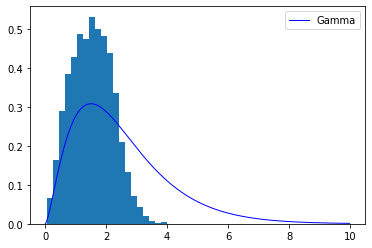

In [12]:
# Let's plot our samples! 
plt.plot(np.arange(0,10, 0.01), Gamma(np.arange(0,10, 0.01), a, b) , 'b-', lw=1, label='Gamma')
plt.hist(xs, bins=20, density=True)
plt.legend()


The samples don't look like they come from the Gamma! What went wrong?

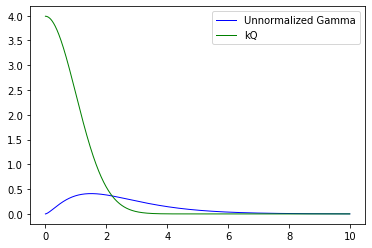

In [13]:
# let's try  plotting out the two graphs
x  = np.arange(0,10, 0.01)
phat = GammaUnnorm(x,a,b)
plt.plot(x, phat , 'b-', lw=1, label='Unnormalized Gamma')

plt.plot(x, k*normpdf.pdf(x), 'g-', lw=1, label='kQ')
plt.legend()

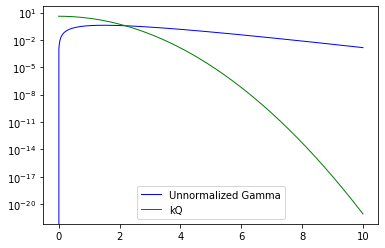

In [14]:
# let's try  plotting out the two graphs in log scale
x  = np.arange(0,10, 0.01)
phat = GammaUnnorm(x,a,b)
plt.semilogy(x, phat , 'b-', lw=1, label='Unnormalized Gamma')

plt.semilogy(x, k*normpdf.pdf(x), 'g-', lw=1, label='kQ')
plt.legend()

So, it looks  like the $\mathcal{N}(0,1)$ was the wrong proposal distribution $q$ to use! 

We'll turn to the  Cauchy distribution which has "fatter" tails. 

##  Estimation with a Cauchy proposal##

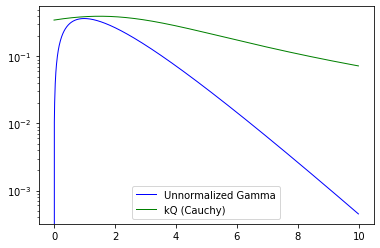

In [15]:
# let's plot this out to be sure. 
x  = np.arange(0,10, 0.01)
phat = GammaUnnorm(x)
plt.plot(x, phat , 'b-', lw=1, label='Unnormalized Gamma')

k = 5.0 # set this to make kq larger than phat
cauchypdf = stats.cauchy(loc = a-1, scale=2*a-1)
plt.semilogy(x, k*cauchypdf.pdf(x), 'g-', lw=1, label='kQ (Cauchy)')
plt.legend()


Estimated: 2.48253 (True: 2.5)


/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


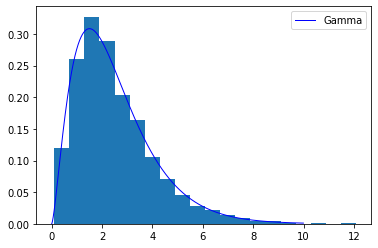

In [16]:
# let's try a Cauchy distribution.
N = 10000
estmean, xs = rejSamplingDemo(a,b,cauchypdf, k, N=N)
print("Estimated: %g (True: %g)"%(estmean, truemean))
# Let's plot our samples! 
plt.plot(np.arange(0,10, 0.01), 
         Gamma(np.arange(0,10, 0.01), a, b) , 
         'b-', lw=1, label='Gamma')
freqs = plt.hist(xs, bins=20, density=True)
plt.legend()

In [17]:
print("Acceptance rate: ", len(xs)/N )

Acceptance rate:  0.2612


# Importance Sampling #

Again, we'll try to estimate the mean of the Gamma distribution.

In [18]:
def impSamplingDemo(a,b, qpdf, N=10000):
    
    x = qpdf.rvs(size=N)
    
    # compute importance weights
    wl = GammaUnnorm(x,a,b)/qpdf.pdf(x)
    wl = wl / np.sum(wl)

    # compute Expectation
    estmean = np.sum(x*wl)
    return estmean, x, wl

In [19]:
# estimate expectation of a distribution
# we'll estimate a Gamma with parameters a, b
truemean = a/b # here,  the true value is a/b

N = 100000
estmean, xs, wl = impSamplingDemo(a,b, cauchypdf, N=N)
print("Estimated: %g (True: %g)"%(estmean, truemean))

Estimated: 2.50408 (True: 2.5)


/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


In [20]:
# compare the mean and variances of running rejection/importance
# sampling many times
N = 50 # number of samples drawn from proposal
M = 1000 # number of repetitions of sampling procedure

rejmeans =  [rejSamplingDemo(a,b,cauchypdf, k, N=N)[0] for  i in range(M)]
impmeans =  [impSamplingDemo(a,b,cauchypdf, N=N)[0] for  i in range(M)]

print("Rejection Sampling Mean (Variance) : %g (%g)"%(np.mean(rejmeans), np.var(rejmeans)))
print("Importance Sampling Mean (Variance): %g (%g)"%(np.mean(impmeans), np.var(impmeans)))

/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Rejection Sampling Mean (Variance) : 2.49106 (0.193048)
Importance Sampling Mean (Variance): 2.51273 (0.0857416)


### Back  to a Normal Proposal Distribution ###
What if we tried a normal proposal again?

In [21]:
# estimate expectation of a distribution
# we'll estimate a Gamma with parameters a, b
truemean = a/b # here,  the true value is a/b

# let's first try a normal(0,1)  distribution.
N = 10000
estmean, xs, wl = impSamplingDemo(a,b, normpdf, N=N)
print("Estimated: %g (True: %g)"%(estmean, truemean))

Estimated: 1.92481 (True: 2.5)


/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


In [22]:
impmeans_normal =  [impSamplingDemo(a,b,normpdf, N=N)[0] for  i in range(M)]

/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """


In [23]:
print("IS using Cauchy: Mean (Variance): %g (%g)"%(np.mean(impmeans), np.var(impmeans)))
print("IS using Normal: Mean (Variance): %g (%g)"%(np.mean(impmeans_normal), np.var(impmeans_normal)))


IS using Cauchy: Mean (Variance): 2.51273 (0.0857416)
IS using Normal: Mean (Variance): 2.12107 (0.121597)


/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


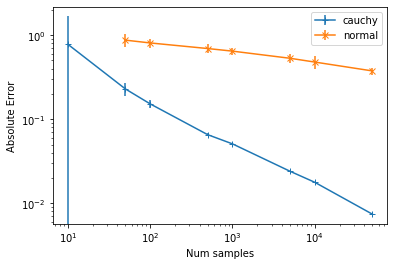

In [24]:
# let's plot how the  error from the  true pi 
# changes as we increase the number of samples
def getErrs(ns, qpdf):
    
    err = np.zeros(len(ns))
    errvar = np.zeros(len(ns))
    M = 100 # internal samples
    for i in range(len(ns)):
        n = ns[i]
        mj = np.zeros(M)
        for j in range(M):
            mj[j] = impSamplingDemo(a,b,qpdf, N=n)[0] 
        err[i] = np.mean(np.abs(mj - truemean))
        errvar[i] = np.var(np.abs(mj - truemean))
        
    return err, errvar

ns = [10,50, 100, 500, 1000, 5000, 10000, 50000]
err_norm, errvar_norm = getErrs(ns, normpdf)        
err_cauchy, errvar_cauchy = getErrs(ns, cauchypdf)

plt.errorbar(ns, err_cauchy, yerr=errvar_cauchy, marker='+', label="cauchy")
plt.errorbar(ns, err_norm, yerr=errvar_norm, marker='x', label="normal")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Num samples")
plt.ylabel("Absolute Error")
plt.legend()


## Metropolis-Hasting Algorithm ##

Next, we'll experiment with the Metropolis-Hasting algorithm. 

In [25]:
import numpy as np

# phat is the unnormalized distribution
# qpdf is the proposal distribution pdf
# qsample is a means of sampling from q
# N is the number of samples we want to draw
# T is the interval at which we record a sample.

def MCMCDemo(x, phat, qpdf, qsample, N, T=100):
    xs = np.zeros(N)
    
    for i in range(N):
        for t in range(T): # record after T samples
            u = np.random.uniform(0,1)
            xc = qsample(x)
            if u < min(1, np.nan_to_num((phat(xc)*qpdf(x,xc)) / (phat(x)*qpdf(xc,x)))):
                x = xc
        xs[i] = x

    estmean = np.mean(xs)
    return estmean, xs
    

In [26]:
#%%time
# set up our distributions
phat = lambda x : GammaUnnorm(x, a=a, b=b)
qpdf = lambda x, mu : stats.norm.pdf(x, mu, 1.0)
qsample = lambda mu : stats.norm.rvs(mu,1.0)

# our parameters
x = 0.0 # the initial x
N = 1000 # number of samples

Nburnin = 1000
T = 50

# start with burnin
MCMCDemo(0, phat, qpdf, qsample, N=Nburnin, T=1)

# sample
estmean, xs = MCMCDemo(x, phat, qpdf, qsample, N=N, T=T)
print("Estimated: %g (True: %g)"%(estmean, truemean))

/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/haroldsoh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Estimated: 2.48205 (True: 2.5)


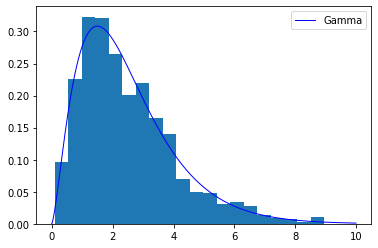

In [27]:
# Let's plot our samples! 
plt.plot(np.arange(0,10, 0.01), 
         Gamma(np.arange(0,10, 0.01), a, b) , 
         'b-', lw=1, label='Gamma')
freqs = plt.hist(xs, bins=20, density=True)
plt.legend()

In [28]:
# diagnosis
autocorrelation_plot(pd.Series(xs))

NameError: name 'autocorrelation_plot' is not defined

### Sampling from a GMM ### 
Let's try a multimodal distribution, e.g., a GMM! Of course, a GMM is pretty easy to sample from; this is purely for demonstration purposes.

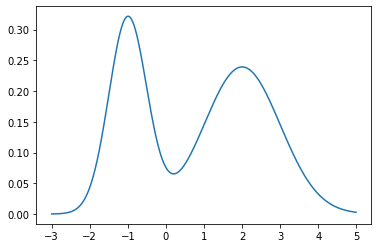

In [29]:
def GMMUnnorm(x, pi, normpdfs):
    logp = 0
    for i in range(pi.shape[0]):
        logp += exp(log(pi[i]) + normpdfs[i].logpdf(x))
    return logp

pi = np.array([0.4, 0.6])
normpdfs = np.array([stats.norm(-1.0,0.5), stats.norm(2.0,1.0)])
truemeanGMM =  pi[0]*normpdfs[0].mean() + pi[1]*normpdfs[1].mean()

x = np.arange(-3.0, 5.0, 0.01)
ps = GMMUnnorm(x, pi, normpdfs)
plt.plot(x,ps)


phat = lambda x : GMMUnnorm(x, pi, normpdfs)
qpdf = lambda x, mu : stats.norm.pdf(x, mu, 1)
qsample = lambda mu : stats.norm.rvs(mu,1)

In [30]:
# our parameters
x = 0.0 # the initial x
N = 1000 # number of samples

Nburnin = 1000
T = 50

# start with burnin
MCMCDemo(0, phat, qpdf, qsample, N=Nburnin, T=1)

# sample
estmean, xs = MCMCDemo(x, phat, qpdf, qsample, N=N, T=T)

print("Estimated: %g (True: %g)"%(estmean, truemeanGMM))

Estimated: 0.812006 (True: 0.8)


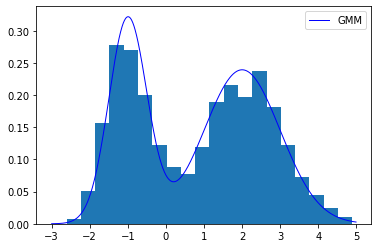

In [31]:
# Let's plot our samples! 
z = np.arange(-3.0, 5.0, 0.01)
plt.plot(z, phat(z), 
         'b-', lw=1, label='GMM')
freqs = plt.hist(xs, bins=20, density=True)
plt.legend()

In [32]:
# diagnosis
autocorrelation_plot(pd.Series(xs))

NameError: name 'autocorrelation_plot' is not defined

## Back to Slides ##

But **why** does MCMC work? For that, we need some theory. 